In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import torch
from transformer_lens import HookedTransformerConfig, HookedTransformer
from transformer_lens import HookedTransformer
from circuits_benchmark.utils.get_cases import get_cases
from circuits_benchmark.utils.iit import make_iit_hl_model
import circuits_benchmark.utils.iit.correspondence as correspondence
import iit.model_pairs as mp

task = get_cases(indices=['3'])[0]
task_idx = task.get_index()
dir_name = f"../InterpBench/{task_idx}"
cfg_dict = pickle.load(open(f"{dir_name}/ll_model_cfg.pkl", "rb"))
cfg = HookedTransformerConfig.from_dict(cfg_dict)
cfg.device = "cuda" if torch.cuda.is_available() else "cpu"
model = HookedTransformer(cfg)
weights = torch.load(f"{dir_name}/ll_model.pth", map_location=cfg.device)
model.load_state_dict(weights)
# turn off grads
model.eval()
model.requires_grad_(False)

# load high level model

def make_model_pair(benchmark_case):
    hl_model = benchmark_case.build_transformer_lens_model()
    hl_model = make_iit_hl_model(hl_model, eval_mode=True)
    tracr_output = benchmark_case.get_tracr_output()
    hl_ll_corr = correspondence.TracrCorrespondence.from_output(
            case=benchmark_case, tracr_output=tracr_output
        )
    model_pair = mp.StrictIITModelPair(hl_model, model, hl_ll_corr)
    return model_pair

In [2]:
from circuits_benchmark.utils.iit.dataset import get_unique_data
max_len = 1000
model_pair = make_model_pair(task)
unique_test_data = get_unique_data(task, max_len=max_len)
def collate_fn(batch):
    encoded_x = model_pair.hl_model.map_tracr_input_to_tl_input(list(zip(*batch))[0])
    return encoded_x

loader = torch.utils.data.DataLoader(unique_test_data, batch_size=256, shuffle=False, drop_last=False, collate_fn=collate_fn)

Moving model to device:  cpu
{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint(), 'blocks.1.attn.hook_k': HookPoint(), 'blocks.1.attn.hook_q': HookPoint(), 'blocks.1.attn.hook_v': HookPoint(), 'blocks.1.attn.hook_z': HookPoint(), 'blocks.1.attn.hook_

In [3]:
from utils.tuned_lens import do_tuned_lens, TunedLensConfig
tuned_lens_results, labels, train_metrics = do_tuned_lens(
    model_pair, loader, 
    TunedLensConfig(
        num_epochs=50,
        lr=1e-2,
    ),
    return_train_metrics=True
)

100%|██████████| 50/50 [00:05<00:00,  8.50it/s]


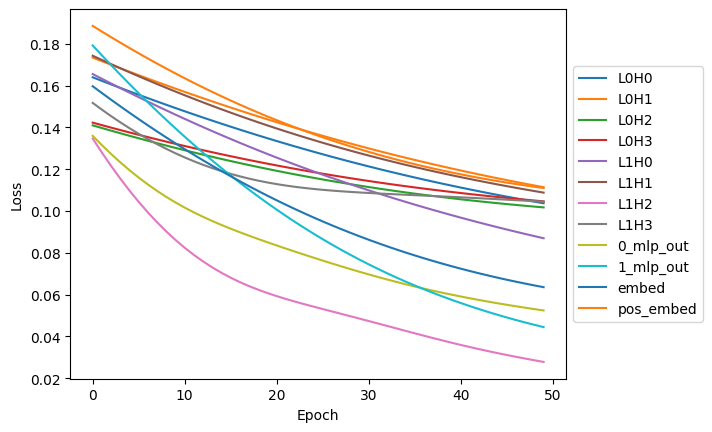

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

metric_df = pd.DataFrame(train_metrics)
metric_df.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Epoch")
plt.ylabel("Loss")
pass

In [5]:
from iit.utils.node_picker import get_all_individual_nodes_in_circuit

nodes = get_all_individual_nodes_in_circuit(model, model_pair.corr)
def convert_ll_node_to_str(node: mp.LLNode):
    if 'attn' in node.name:
        block = node.name.split('.')[1]
        head = node.index.as_index[2]
        return f"L{block}H{head}"
    if 'mlp' in node.name:
        block = node.name.split('.')[1]
        return f"{block}_mlp_out"

nodes = [convert_ll_node_to_str(node) for node in nodes]
nodes

['0_mlp_out', 'L1H2']

In [6]:
from scipy import stats
import plotly.graph_objects as go
# k = "L1H1"
k = "1_mlp_out"
in_circuit_str = "in circuit" if k in nodes else "not in circuit"
fig = go.Figure()

for i in range(tuned_lens_results[k].shape[1]):
    y = labels[:, i].squeeze().detach().cpu().numpy()
    x = tuned_lens_results[k][:, i].detach().cpu().numpy().squeeze()
    if model_pair.hl_model.is_categorical():
        y = y.argmax(axis=-1)
        x = x.argmax(axis=-1)
        
    pearson_corr = stats.pearsonr(x, y)
    fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name=f"pos {i}, corr: {pearson_corr[0]:.2f}"))

fig.update_layout(title=f"Logit Lens Results for {k} ({in_circuit_str})", yaxis_title="True Logits", xaxis_title="Logit Lens Results")
fig.show()

In [22]:
import pandas as pd
import plotly.express as px
import numpy as np

def plot_combined_pearson(tuned_lens_results, labels, model_pair, nodes, abs_corr=True):
    pearson_corrs = {}
    for k in tuned_lens_results.keys():
        x = tuned_lens_results[k].detach().cpu().numpy().squeeze()
        y = labels.detach().cpu().numpy().squeeze()
        if model_pair.hl_model.is_categorical():
            y = y.argmax(axis=-1)
            x = x.argmax(axis=-1)
        for i in range(x.shape[1]): 
            pearson_corr = stats.pearsonr(x[:, i], y[:, i])
            k_ = k + "(IC)" if k in nodes else k
            if k_ not in pearson_corrs:
                pearson_corrs[k_] = {}
            if np.isnan(pearson_corr.correlation):
                pearson_corrs[k_][str(i)] = 0
            elif abs_corr:
                pearson_corrs[k_][str(i)] = abs(pearson_corr.correlation) 
            else:
                pearson_corrs[k_][str(i)] = pearson_corr.correlation

    pearson_corrs = pd.DataFrame(pearson_corrs)
    fig = px.imshow(pearson_corrs, 
            # set color map
                color_continuous_scale="Viridis",
                # set axis labels   
                labels=dict(y="Position", x="Layer/Head", color="Pearson Correlation"),
    )
    # remove margins around plot
    fig.update_layout(margin=dict(l=0, r=0, t=1, b=0))

    # make xticks bigger
    fig.update_xaxes(tickfont=dict(size=15))

    fig.show()

plot_combined_pearson(tuned_lens_results, labels, model_pair, nodes, abs_corr=False)

/var/folders/_k/_46xyqdj165bdcyw79k6758w0000gn/T/ipykernel_75371/960397476.py:14: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

